In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
59382,Haryana CM responds as Ex-CM slams him over Ma...,Haryana CM Manohar Lal Khattar has responded t...
86740,Women led camels in past: Saudi Prince against...,Saudi Prince Faisal Bin Abdullah has denounced...
28423,Woman footballer accuses coach of buying playe...,A woman footballer in Rajasthan slapped her co...
4153,Seal pup with umbilical cord naps on plastic b...,An amateur photographer named John Evered has ...
37655,Javed slams Muslim cleric for cow slaughter on...,Slamming Muslim cleric Tanveer Hashim for sayi...
55277,Skull-shaped asteroid to fly past Earth again ...,Spain-based astronomers estimate that the skul...
84719,Important to tell today's generation about Eme...,Filmmaker Madhur Bhandarkar has said that it i...
88384,Boy tries pranking father for more cash with W...,A Chinese boy tried pranking his father for mo...
7272,Revival of Italy's Pininfarina an 'unfinished ...,Italian car designer Pininfarina's turnaround ...
75120,Iran can't hold world hostage with nuclear dea...,US Ambassador to the UN Nikki Haley has said t...


* 추상적 요약시 : text를 본문, headlines를 요약 데이터로 사용
* 추출적 요약시 : text열만 사용

## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

__1. 중복 샘플 확인 후 제거__

In [5]:
print('headlines 중복 제외 샘플 수:',  data['headlines'].nunique())
print('text 중복 제외 샘플 수:', data['text'].nunique())

headlines 중복 제외 샘플 수: 98280
text 중복 제외 샘플 수: 98360


In [6]:
# text 중복 샘플 drop
data.drop_duplicates(subset=['text'], inplace=True)
print('중복 데이터 제거 후 text 데이터 수:', len(data))

중복 데이터 제거 후 text 데이터 수: 98360


__2. Null 값 확인 후 제거__

In [7]:
print(data.isna().sum())

headlines    0
text         0
dtype: int64


__3. 텍스트 정규화 준비__

In [8]:
# 정규화 사전 생성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


__4. text에서 불용어 제거__

In [9]:
print('불용어 개수:', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과물 확인해보기

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_title = 'Great way to start (or finish) the day!!!'

print('text: ', preprocess_sentence(temp_text))
print('title:', preprocess_sentence(temp_title, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
title: great way to start the day


__전체 text 데이터 전처리__

In [12]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print('text 전처리 후:', clean_text[:5])

text 전처리 후: ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure cr

__전체 headlines 데이터 전처리__

In [13]:
clean_headlines=[]
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print('headlines 전처리 후:', clean_headlines[:5])

headlines 전처리 후: ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


__빈 값이 있는 샘플이 있다면 모두 Null로 대체__

In [14]:
data['text']=clean_text
data['headlines']=clean_headlines

data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

결측치 없음

In [16]:
print('정제 후 전체 샘플수:', len(data))

정제 후 전체 샘플수: 98360


__5. 샘플의 최대 길이 정하기__

text, headlines의 최소, 최대, 평균 길이 구하고 길이 분포 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


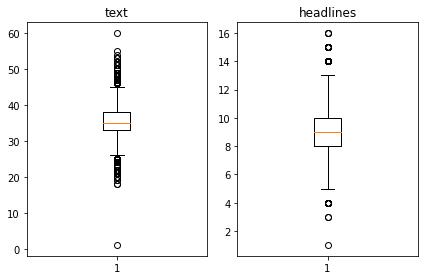

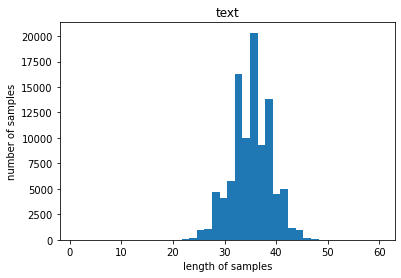

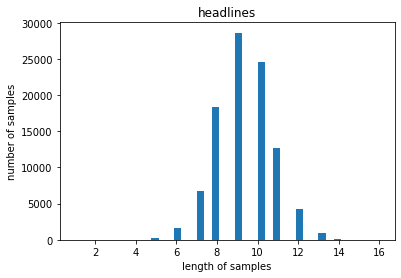

In [17]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text와 headline 최대 길이가 60, 16으로 별로 길지 않아 제한하지 않음

In [18]:
text_max_len = 60
headline_max_len = 16

In [19]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플 비율: %s'%(max_len, (count / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len, data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플 비율: 1.0


__정해진 길이보다 긴 데이터 제외__

In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


__6. headlines 데이터에 시작 토큰, 종료 토큰 추가__

In [22]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sos ' + x)
data['decoder_output'] = data['headlines'].apply(lambda x : x + ' eos')
data.head()

,headlines,text,decoder_input,decoder_output
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sos upgrad learner switches to career in ml al...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sos delhi techie wins free food from swiggy fo...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sos new zealand end rohit sharma led india mat...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sos aegon life iterm insurance plan helps cust...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sos have known hirani for yrs what if metoo cl...,have known hirani for yrs what if metoo claims...


__7. 인코더의 입력, 디코더의 입출력을 각가 numpy 타입으로 저장__

In [23]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_output'])

In [24]:
print('encoder input의 shape:', encoder_input.shape)
print('decoder input(target)의 shape:', decoder_input.shape)

encoder input의 shape: (98360,)
decoder input(target)의 shape: (98360,)


__8. 샘플 섞은 후 훈련과 테스트 데이터 분리(8:2)__

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target,
random_state=42,
test_size=0.2)
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
decoder_input[50]

'sos th us prez shakes hands with each passenger on his flight'

In [27]:
decoder_target[50]

'th us prez shakes hands with each passenger on his flight eos'

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


__9. encoder 데이터 단어집합(vocabulary) 생성 및 정수 인코딩__

In [30]:
src_tokenizer = Tokenizer()
# 단어 집합 생성과 동시에 고유 정수 부여
src_tokenizer.fit_on_texts(encoder_input_train)

In [31]:
len(src_tokenizer.word_index)

69655

text 학습 데이터 내에서 빈도수 7회 미만인 단어의 비중은?

In [32]:
threshold=7
total_count = len(src_tokenizer.word_index)
rare_count = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_count = rare_count + 1
        rare_freq = rare_freq + value
        
print('단어집합 내의 단어 개수:', total_count)
print('빈도수 %s 번 이하인 희귀 단어 개수: %s'%(threshold-1, rare_count))
print('단어집합 - 희귀단어시, 단어 집합 내의 단어 개수: %s'%(total_count - rare_count))
print('단어집합 내 희귀 단어 비율:', (rare_count / total_count)*100)
print('전체 단어 빈도 중 희귀 단어 등장 비율:', (rare_freq / total_freq)*100)

단어집합 내의 단어 개수: 69655
빈도수 6 번 이하인 희귀 단어 개수: 47507
단어집합 - 희귀단어시, 단어 집합 내의 단어 개수: 22148
단어집합 내 희귀 단어 비율: 68.20328763190008
전체 단어 빈도 중 희귀 단어 등장 비율: 3.491385865432662


희귀 단어가 전체 단어의 약 68 %를 차지하지만, 희귀 단어 등장 빈도는 약 3.5 % 밖에 되지 않음. 등장 빈도 7회 미만인 단어는 정수 인코딩 하지 않고, 훈련 데이터에서 제거

In [33]:
src_vocab = 22000
src_tokenizer_2 = Tokenizer(num_words=src_vocab)
src_tokenizer_2.fit_on_texts(encoder_input_train)

encoder_input_train과 test를 정수 시퀀스로 변환

In [34]:
encoder_input_train = src_tokenizer_2.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer_2.texts_to_sequences(encoder_input_test)
print(encoder_input_train[0])
print(encoder_input_test[0])

[904, 169, 1, 368, 55, 1317, 541, 12, 862, 394, 294, 288, 1007, 6618, 271, 395, 9146, 17468, 624, 1917, 4, 904, 1, 659, 2703, 456, 145, 908, 1202]
[119, 419, 4187, 720, 11860, 7227, 5, 16, 122, 41, 2770, 136, 5777, 935, 136, 560, 451, 6149, 2473, 500, 1172, 1424, 949, 41, 19, 455, 652, 2501, 2473, 11860, 1, 167, 20, 190, 527, 400, 1496, 67, 2473]


__10. decoder 데이터 단어집합(vocabulary) 생성 및 정수 인코딩__

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [36]:
threshold = 7
total_count = len(tar_tokenizer.word_index) 
rare_count = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_count = rare_count + 1
        rare_freq = rare_freq + value

print('단어집합 내의 단어 개수:', total_count)
print('빈도수 %s 번 이하인 희귀 단어 개수: %s'%(threshold-1, rare_count))
print('단어집합 - 희귀단어시, 단어 집합 내의 단어 개수: %s'%(total_count - rare_count))
print('단어집합 내 희귀 단어 비율:', (rare_count / total_count)*100)
print('전체 단어 빈도 중 희귀 단어 등장 비율:', (rare_freq / total_freq)*100)

단어집합 내의 단어 개수: 30042
빈도수 6 번 이하인 희귀 단어 개수: 20521
단어집합 - 희귀단어시, 단어 집합 내의 단어 개수: 9521
단어집합 내 희귀 단어 비율: 68.30770254976366
전체 단어 빈도 중 희귀 단어 등장 비율: 5.292172947634614


In [37]:
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [38]:
len(tar_tokenizer.word_index)

30043

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4, 49, 271, 97, 49, 426, 183, 1600, 559, 410, 398], [1, 30, 323, 179, 11, 1957, 1500, 13, 5006], [1, 511, 1929, 133, 680, 2304, 858, 2475], [1, 45, 284, 133, 4270, 3, 166, 2104, 4, 1895], [1, 31, 10, 1179, 2681, 17, 769, 184]]
target
decoder  [[4, 49, 271, 97, 49, 426, 183, 1600, 559, 410, 398, 2], [30, 323, 179, 11, 1957, 1500, 13, 5006, 2], [511, 1929, 133, 680, 2304, 858, 2475, 2], [45, 284, 133, 4270, 3, 166, 2104, 4, 1895, 2], [31, 10, 1179, 2681, 17, 769, 184, 2]]


decoder train과 test에서 headlines 길이가 1인 경우(sos나 eos만 포함) 해당 샘플 삭제

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


__11. 패딩 넣기__

In [41]:
text_max_len = 60
headline_max_len = 16

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')
print(decoder_input_test[0])

[   1 1977 3613   52   28 2962  173    3 2302    0    0    0    0    0
    0    0]


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

__1. 모델 설계하기__
* 1.1 인코더 설계

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

src_vocab = 22000
tar_vocab = 9500

# 인코더 입력 크기 지정
encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 1.2 디코더 설계

In [43]:
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

* 1.3 디코더 출력층 설계

In [44]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

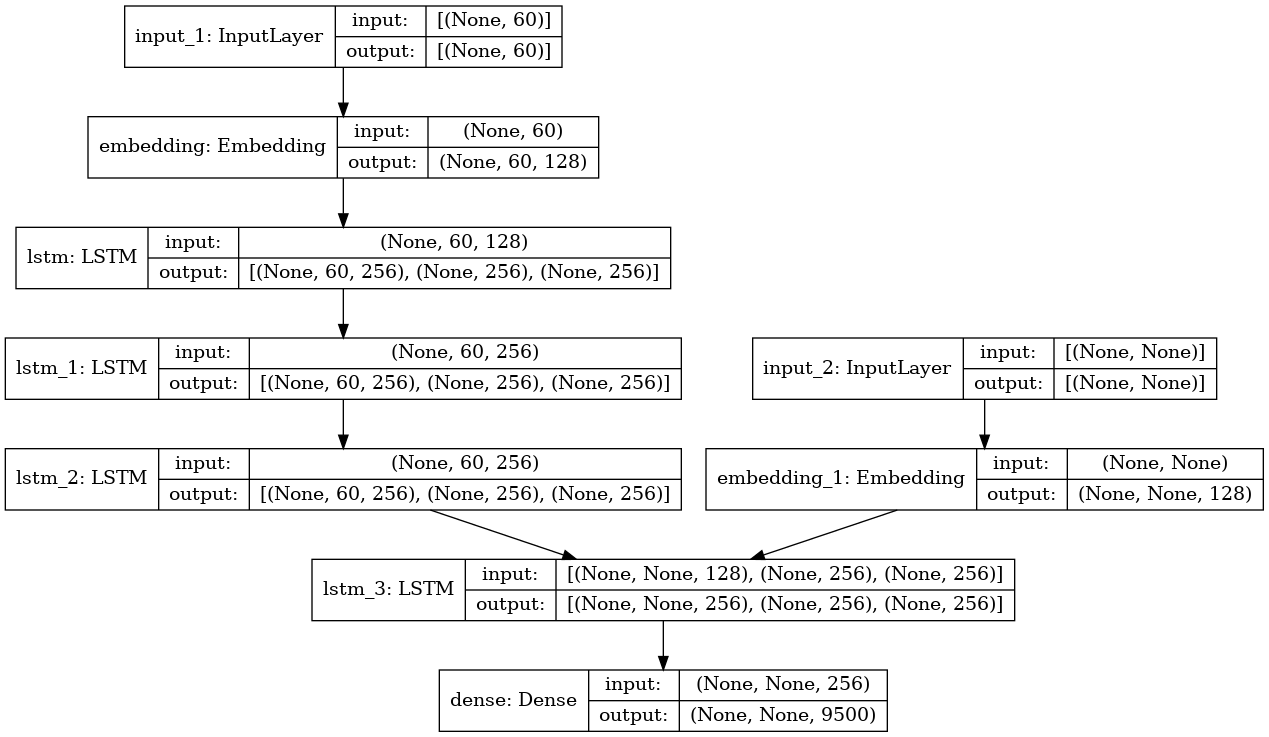

In [45]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

__2. 어텐션 메커니즘 구현__

In [46]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

# attention 결과와 decoder의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

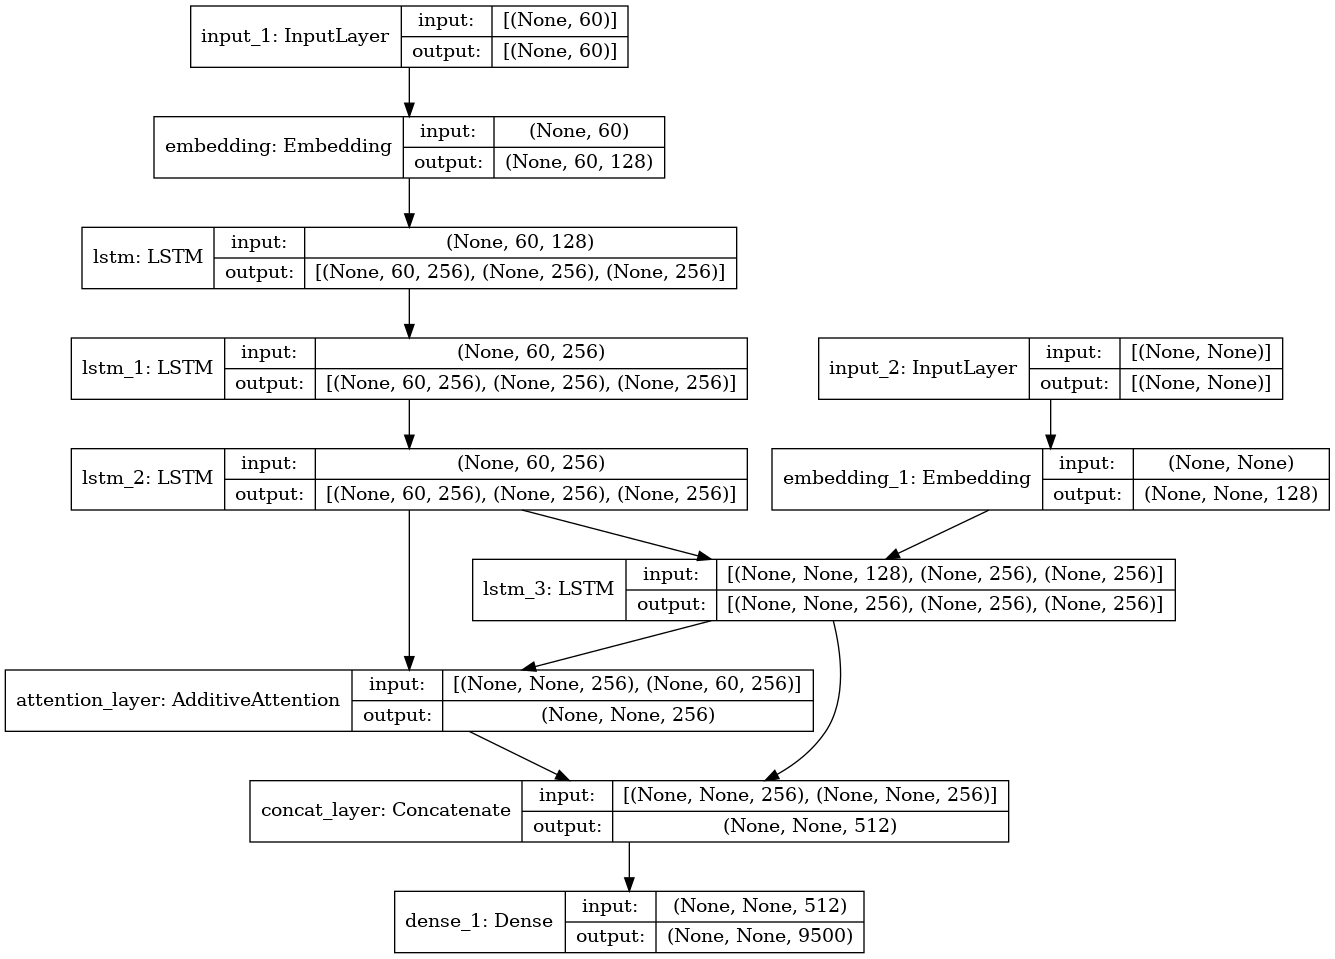

In [47]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

__3. 모델 훈련하기__

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
                   validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                   batch_size=256, callbacks=[es], epochs=100)

Epoch 1/100
308/308 [==============================] - 65s 145ms/step - loss: 4.2549 - val_loss: 3.8792
Epoch 2/100
308/308 [==============================] - 42s 137ms/step - loss: 3.7618 - val_loss: 3.6015
Epoch 3/100
308/308 [==============================] - 43s 138ms/step - loss: 3.5142 - val_loss: 3.4131
Epoch 4/100
308/308 [==============================] - 42s 138ms/step - loss: 3.3245 - val_loss: 3.2681
Epoch 5/100
308/308 [==============================] - 43s 139ms/step - loss: 3.1671 - val_loss: 3.1585
Epoch 6/100
308/308 [==============================] - 42s 138ms/step - loss: 3.0362 - val_loss: 3.0765
Epoch 7/100
308/308 [==============================] - 43s 138ms/step - loss: 2.9238 - val_loss: 3.0131
Epoch 8/100
308/308 [==============================] - 43s 138ms/step - loss: 2.8284 - val_loss: 2.9573
Epoch 9/100
308/308 [==============================] - 43s 138ms/step - loss: 2.7435 - val_loss: 2.9124
Epoch 10/100
308/308 [==============================] - 43s 139m

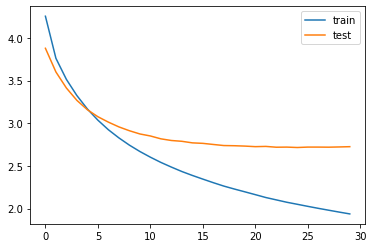

In [60]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

__4. 인퍼런스 모델 구현__

In [61]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 인퍼런스를 위한 모델 설계를 별도로 해주어야 함

In [62]:
# encoder 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

__어텐션 메커니즘을 사용하는 출력층 설계__

In [63]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

__인퍼런스 단계에서 단어 시퀀스 완성하는 함수 생성__

In [64]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0,0] = tar_word_to_index['sos']
    
    stop_condition = False
    decoded_sentence=''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token!='eos'):
            decoded_sentence += ' ' + sampled_token
        
        if (sampled_token == 'eos' or len(decoded_sentence.split())>=(headline_max_len-1)):
            stop_condition = True
            
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        e_h, e_c = h, c
        
    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [65]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sos']) and i!=tar_word_to_index['eos']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [72]:
for i in [7, 77, 777, 7777]:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headline(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : armed fan face covered black cloth brandishing long iron bar rushed onto pitch croatian football league game attempt attack match referee earlier match play halted several minutes fireworks set home fan 
실제 요약 : video armed fan invades pitch to attack football referee 
예측 요약 :  fan throws football as fan city for fan city


원문 : kkr rounder andre russell slammed sixes knock csk ipl tuesday russell holds record highest score number seven batsman ipl overtaking csk dwayne bravo run record russell also became first batsman slam six sixes csk chennai ipl 
실제 요약 : russell hits records top ipl score by no batsman 
예측 요약 :  csk score csk st ipl highest score scorer in ipl


원문 : indian batsman shikhar dhawan said performance tour south africa helped earn contract bcci dhawan scored two half centuries one century odi series win south africa said dream come true perform like south africa 
실제 요약 : south africa performance helped me win cr contract dhawan 
예측 요약 :  dhawan has been an captain

## Step 5. Summa을 이용해서 추출적 요약해보기

In [56]:
import requests
from summa.summarizer import summarize

In [57]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [68]:
from summa.summarizer import summarize

for i in [77,777,7777]:
    print('원본 텍스트: ', data['text'][i])
    print('원본 요약 텍스트: ', data['headlines'][i])
    print('추출적 요약 텍스트: ', summarize(data['text'][i], ratio=0.25, words=15))
    print("\n")

원본 텍스트:  Government officials on Wednesday said that a swine flu outbreak has killed 76 people this year in Rajasthan. Colder weather has worsened the seasonal outbreak of the H1N1 virus in the country, officials added. Rajasthan recorded more than a third of all swine flu deaths in India with Jodhpur being the worst affected area in the state, officials said.
원본 요약 텍스트:  Swine flu outbreak kills 76 in Rajasthan
추출적 요약 텍스트:  Government officials on Wednesday said that a swine flu outbreak has killed 76 people this year in Rajasthan.


원본 텍스트:  World number one Novak Djokovic defeated Lucas Pouille in the semi-final to reach Australian Open men's singles final for the seventh time. The six-time Australian Open champion won the match with a scoreline of 6-0, 6-2, 6-2 in 83 minutes. Djokovic will face world number two Rafael Nadal in the summit clash in a repeat of the 2012 final. 
원본 요약 텍스트:  World no. 1 Djokovic to face world no. 2 Nadal in Aus Open final
추출적 요약 텍스트:  World number one N

[추상적 요약]
* 팬들은 팬시를 위해 축구를 팬시로 던집니다
* csk 점수 csk stip ipl에서 가장 높은 점수를 받은 사람
* 다완은 주장이었지만 다완은
* 뭄바이에서 샤루크 칸을 위해 열릴 아미샤

[추출적 요약 텍스트]

* 수요일 정부 관리들은 올해 라자스탄에서 돼지 독감이 발생해 76명이 사망했다고 말했습니다.
* 세계 랭킹 1위 노박 조코비치가 준결승에서 루카스 푸일을 꺾고 7번째 호주 오픈 남자 단식 결승에 올랐습니다.
* 보도에 따르면 제트 에어웨이즈는 일부 조종사들이 회비 미납에 대해 "아프다"고 보고한 후 일요일 다양한 목적지로 가는 최소 14편의 항공편을 취소했습니다.


__문법 완성도와 핵심단어 포함 측면 모두 추출적 요약이 우수하다.__